In [12]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install jamo

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 56.7 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-10 07:59:31--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix

import os

In [21]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

In [22]:
train_data

,comments,hate
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,1
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,0
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,1
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,0
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,1
...,...,...
24187,잘난척좀그만해ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0
24188,응 갈데 없어 ㅋㅋ,0
24189,너 돈은있니 ㅋㅋㅋㅋㅋㅋㅋ,0
24190,코휘향 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0


In [19]:
train_data['comments'] = train_data['comments'].apply(lambda x: spliter(x))
train_data['comments'] = train_data['comments'].apply(lambda x: x.split(' '))

In [14]:
mecab = Mecab()
stopwords = ['에게', '를', '의', '로', '으로', '고', '하고', '듯', '인', '하는', '와', '과', '을', '들', '임', '게', '면', '가', '이가',
             '도', '마저', '한', '면', '네', '이', '는', '하', '다', '은', '지', '에', '거', '나', '보', '는데', '아', '나', '만', '에서',
             '음', '니', '냐', '만', '야', '요', '에요', '든', '걸', '이다', '건', '여']

In [15]:
!pip install jamo

In [16]:
from jamo import h2j, j2hcj

def spliter(text):
    return j2hcj(h2j(text))

In [18]:
from gensim.models import FastText
ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_200k_spliter.model')

In [23]:
train_data['comments']

0          현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네
1          한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ
2        못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...
3                             화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데
4             사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노
                               ...                        
24187                     잘난척좀그만해ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
24188                                           응 갈데 없어 ㅋㅋ
24189                                       너 돈은있니 ㅋㅋㅋㅋㅋㅋㅋ
24190                                       코휘향 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
24191                          갈데엊ㅅ는줄알어 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
Name: comments, Length: 24192, dtype: object

In [ ]:
train_tokenized = []
for sentence in train_data['comments']:
    temp_X = mecab.morphs(sentence)
    temp_X = [spliter(word) for word in temp_X if not word in stopwords]
    train_tokenized.append(temp_X)
train_tokenized

In [25]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = train_tokenized
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [26]:
X_pad

array([[  3338,  31820,   4997, ...,      0,      0,      0],
       [  4636,  14169,  45478, ...,      0,      0,      0],
       [   567,   6082,    947, ...,      0,      0,      0],
       ...,
       [  2349,    274,  10118, ...,      0,      0,      0],
       [  4520, 161466, 226598, ...,      0,      0,      0],
       [  4809,   2607,   2861, ...,      0,      0,      0]], dtype=int32)

In [27]:
y_train = train_data['hate'].values
y_train

array([1, 0, 1, ..., 0, 0, 0])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_train, test_size=0.1, shuffle=True, random_state=123)

In [29]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = input_length, weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(embedding_matrix=ft_model.wv.vectors, input_length=input_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           25320900  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,520,709
Trainable params: 199,809
Non-trainable params: 25,320,900
______________________________________

In [30]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

Epoch 1/20
218/218 [==============================] - 227s 1s/step - loss: 0.4753 - accuracy: 0.8063 - val_loss: 0.4596 - val_accuracy: 0.8079
Epoch 2/20
218/218 [==============================] - 221s 1s/step - loss: 0.4537 - accuracy: 0.8115 - val_loss: 0.4386 - val_accuracy: 0.8136
Epoch 3/20
218/218 [==============================] - 221s 1s/step - loss: 0.4300 - accuracy: 0.8212 - val_loss: 0.4166 - val_accuracy: 0.8269
Epoch 4/20
218/218 [==============================] - 222s 1s/step - loss: 0.4047 - accuracy: 0.8356 - val_loss: 0.4158 - val_accuracy: 0.8269
Epoch 5/20
218/218 [==============================] - 221s 1s/step - loss: 0.3795 - accuracy: 0.8473 - val_loss: 0.3995 - val_accuracy: 0.8397
Epoch 6/20
218/218 [==============================] - 222s 1s/step - loss: 0.3596 - accuracy: 0.8556 - val_loss: 0.3858 - val_accuracy: 0.8446
Epoch 7/20
218/218 [==============================] - 227s 1s/step - loss: 0.3460 - accuracy: 0.8618 - val_loss: 0.3937 - val_accuracy: 0.8488

In [31]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [54]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [57]:
y_train_preds = []
y_test_preds = []

for i in range(len(y_train_pred)):
  y_train_preds.append([float(1 - y_train_pred[i]), y_train_pred[i][0]])
for i in range(len(y_test_pred)):
  y_test_preds.append([float(1 - y_test_pred[i]), y_test_pred[i][0]])

In [59]:
y_train_preds = np.argmax(y_train_preds, axis=1)
y_test_preds = np.argmax(y_test_preds, axis=1)

In [48]:
text = [spliter('안녕하세요? 시발 개빡치네')]
sample = pad_sequences(
    sequences=vectorize_data(text, vocab=ft_model.wv.vocab),
    maxlen=input_length,
    padding='post')

Vectorize sentences... (done)


In [49]:
sample

array([[  1729,  78966,   1728,   1728,  21392,   1729,    693,  78966,
          2861,  60100,   1729, 378284,   2861,  26897,   2860,  78966,
         28740,  36642,  36943,  80231,  78966,  36642,  20037,  26897,
          1728,  60100,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [50]:
model.predict(sample)

array([[0.99692446]], dtype=float32)

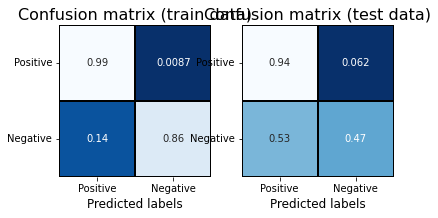

In [63]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_preds, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_preds, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

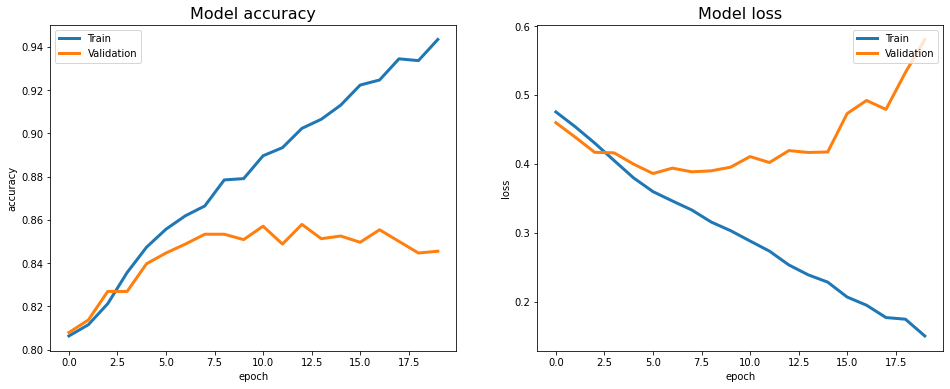

In [37]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [65]:
model.save('/content/drive/MyDrive/Colab Notebooks/LM/ft_200k_spliter_simple_BiLSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LM/ft_200k_spliter_simple_BiLSTM/assets


In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           25320900  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,520,709
Trainable params: 199,809
Non-trainable params: 25,320,900
______________________________________

In [67]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LM/ft_200k_spliter_simple_BiLSTM')

In [68]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           25320900  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,520,709
Trainable params: 199,809
Non-trainable params: 25,320,900
______________________________________

In [70]:
new_model.predict(sample)

array([[0.99692446]], dtype=float32)